In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
import draw_cnf_mat

import xgboost
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from os.path import exists
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import numpy as np
import time
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
X = np.loadtxt('data/latent_data_miRNA.csv', delimiter=',')


y = np.loadtxt('data/encoded_labels.csv')

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

input_dim=X.shape[1]

PC= 'Lenovo'
dataset= 'Pan'

num_epochs=200
batch_size=128

num_classes=len(np.unique(y))

In [3]:
#produce results
path = 'data/results_miRNA/'
def write_results(results, path):
    
    file_exists = exists(path)
    if not(file_exists):
        with open(path,"a+") as f:
            f.write(results)
            f.write("\n")
    else:
        with open(path,"a+") as f:
            f.write(results)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.20, random_state=42)



def create_model():
    
    #early_stop = EarlyStopping(monitor='loss', patience=2)
    model = Sequential()
        
    model.add(Dense(128, activation='relu', input_shape=(input_dim,),kernel_initializer='random_uniform'))
    model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))

    '''model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
    model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
    model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))

    model.add(Dense(num_classes, activation='softmax',kernel_initializer='random_uniform'))'''
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    
    return model

2023-03-08 01:06:54.177732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 01:06:54.594942: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 01:06:54.594964: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-08 01:06:55.262199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
def run_model(i, X,x_train , y_train, x_test , y_test):
    
    t_temp=time.time()
    #individual classifier
    input_dim=x_train.shape[1]

    model1=create_model()
    #hist = model1.fit(x_train , y_train , epochs=20)
    #hist = model1.fit(x_train , y_train , epochs=20, batch_size=5, verbose=0)
    print(x_train.shape)
    hist = model1.fit(x_train , y_train , epochs=num_epochs, batch_size=batch_size, verbose=0)
    y_predict=model1.predict(x_test)
    y_predict=np.argmax(y_predict,axis=1)

    #_, accuracy = model1.evaluate(x_test, y_test)
    #Accuracy
    acc=accuracy_score(y_test, y_predict)
    prc=precision_score(y_test, y_predict, average='weighted')
    rec=recall_score(y_test, y_predict, average='weighted')
    f1=f1_score(y_test, y_predict, average='weighted')
    
 
    results=''
    if (i==0) :
        results='Dataset:' + dataset + '=============================================\n'
        
    results += 'DL:%d' %(i) + ', Acc: %.2f' % (acc*100) + ', Pre: %.2f' % (prc*100)
    results += ', Rec: %.2f' % (rec*100) + ', F1: %.2f' % (f1*100) + ', T:%.2f ' % (time.time()-t_temp) + ', PC:Tan'
    results += ', Eb:%d ' %(num_epochs) + ', Bs:%d ' %(batch_size) + '\n'
    
    path2= path + "Res_Singl_DL_Original.txt" # the name of the file
    write_results(results, path2)
    predictions=model1.predict(X)
    max_indices = np.argmax(predictions,axis=1)


    return np.array(max_indices)

In [6]:

t=time.time()
predictions=run_model(0, X,x_train , y_train, x_test , y_test)
for i in range(1,5):
    predictions=np.vstack((predictions,run_model(i, X,x_train , y_train, x_test , y_test)))

predictions= np.transpose(predictions)

# concat predictions with olriginal features
new_X=np.concatenate((X, predictions), axis=1)
#new_X=predictions #np.concatenate((X, predictions), axis=1)
#====z_score normalization
scaler = StandardScaler()
scaler.fit(new_X)
new_X = scaler.fit_transform(new_X)
print(new_X.shape, predictions.shape)

new_x_train,new_x_test,y_train,y_test = train_test_split(new_X,y,test_size = 0.20, random_state=42)

input_dim=new_X.shape[1]


2023-03-08 01:06:56.489359: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-08 01:06:56.489410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alandoli-Lenovo-Z50-70): /proc/driver/nvidia/version does not exist
2023-03-08 01:06:56.489856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(4992, 128)
196/196 [==============================] - 0s 1ms/step
(4992, 128)
196/196 [==============================] - 0s 1ms/step
(4992, 128)
196/196 [==============================] - 0s 1ms/step
(4992, 128)
196/196 [==============================] - 0s 1ms/step
(4992, 128)
196/196 [==============================] - 0s 1ms/step
(6241, 133) (6241, 5)


In [7]:
input_dim=new_x_train.shape[1]

NN_clf1=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
NN_clf1._estimator_type = "classifier"
NN_clf2=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
NN_clf2._estimator_type = "classifier"
NN_clf3=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
NN_clf3._estimator_type = "classifier"
NN_clf4=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
NN_clf4._estimator_type = "classifier"
NN_clf5=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
NN_clf5._estimator_type = "classifier"
input_dim


/tmp/ipykernel_31519/703522063.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  NN_clf1=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
/tmp/ipykernel_31519/703522063.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  NN_clf2=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
/tmp/ipykernel_31519/703522063.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  NN_clf3=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
/tmp

133

In [8]:
rfc = RandomForestClassifier()
knn =  KNeighborsClassifier()
xgb = xgboost.XGBClassifier()
LR=LogisticRegression(solver='liblinear')
intermediate = [('NN1', NN_clf1), ('NN2', NN_clf2), ('NN3', NN_clf3), ('NN4', NN_clf4),
             ('NN5', NN_clf5),('rfc', rfc),('LR', LR),('xgb', xgb), ]
intermediate


[('NN1', <keras.wrappers.scikit_learn.KerasClassifier at 0x7f056e1baf20>),
 ('NN2', <keras.wrappers.scikit_learn.KerasClassifier at 0x7f056e14f610>),
 ('NN3', <keras.wrappers.scikit_learn.KerasClassifier at 0x7f056e14f8b0>),
 ('NN4', <keras.wrappers.scikit_learn.KerasClassifier at 0x7f055d60ead0>),
 ('NN5', <keras.wrappers.scikit_learn.KerasClassifier at 0x7f055d54f9d0>),
 ('rfc', RandomForestClassifier()),
 ('LR', LogisticRegression(solver='liblinear')),
 ('xgb',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=No

In [9]:
# run after ad preictions of first level
t1=time.time()
i=0
results="Dataset: " + dataset + "================================\n"
clf = [NN_clf1,NN_clf2,NN_clf3,NN_clf4, NN_clf5, rfc, LR, xgb]
for algo in clf:
    t_temp=time.time()
    y_predict = cross_val_predict(algo,new_X,y, cv=3) 
    #score = cross_val_score( algo,new_X,y,cv = 10,scoring = 'accuracy')
    #print("The accuracy score of {} is:".format(algo),score.mean(), "time: ", time.time()-t_temp)
    acc=accuracy_score(y_predict,y)
    prc=precision_score(y_predict,y, average='weighted')
    rec=recall_score(y_predict,y, average='weighted')
    f1=f1_score(y_predict,y, average='weighted')


    results = 'DL:%d' %(i) + ', Acc: %.2f' % (acc*100) + ', Pre: %.2f' % (prc*100)
    results += ', Rec: %.2f' % (rec*100) + ', F1: %.2f' % (f1*100) + ', T:%.2f ' % (time.time()-t_temp) + ', PC:Tan'
    results += ', Eb:%d ' %(num_epochs) + ', Bs:%d ' %(batch_size) + '\n'
    
    path2= path + "Res_Singl_DL_after.txt" # the name of the file
    write_results(results, path2)

    i=i+1
    #print(results)

    '''path="results/Res_Singl_DL_Original.txt" # the name of the file
    write_results(results, path)'''

print("Done...in time: ", time.time()-t1)

65/65 [==============================] - 0s 1ms/step
Done...in time:  297.4114580154419


40/40 [==============================] - 0s 1ms/step


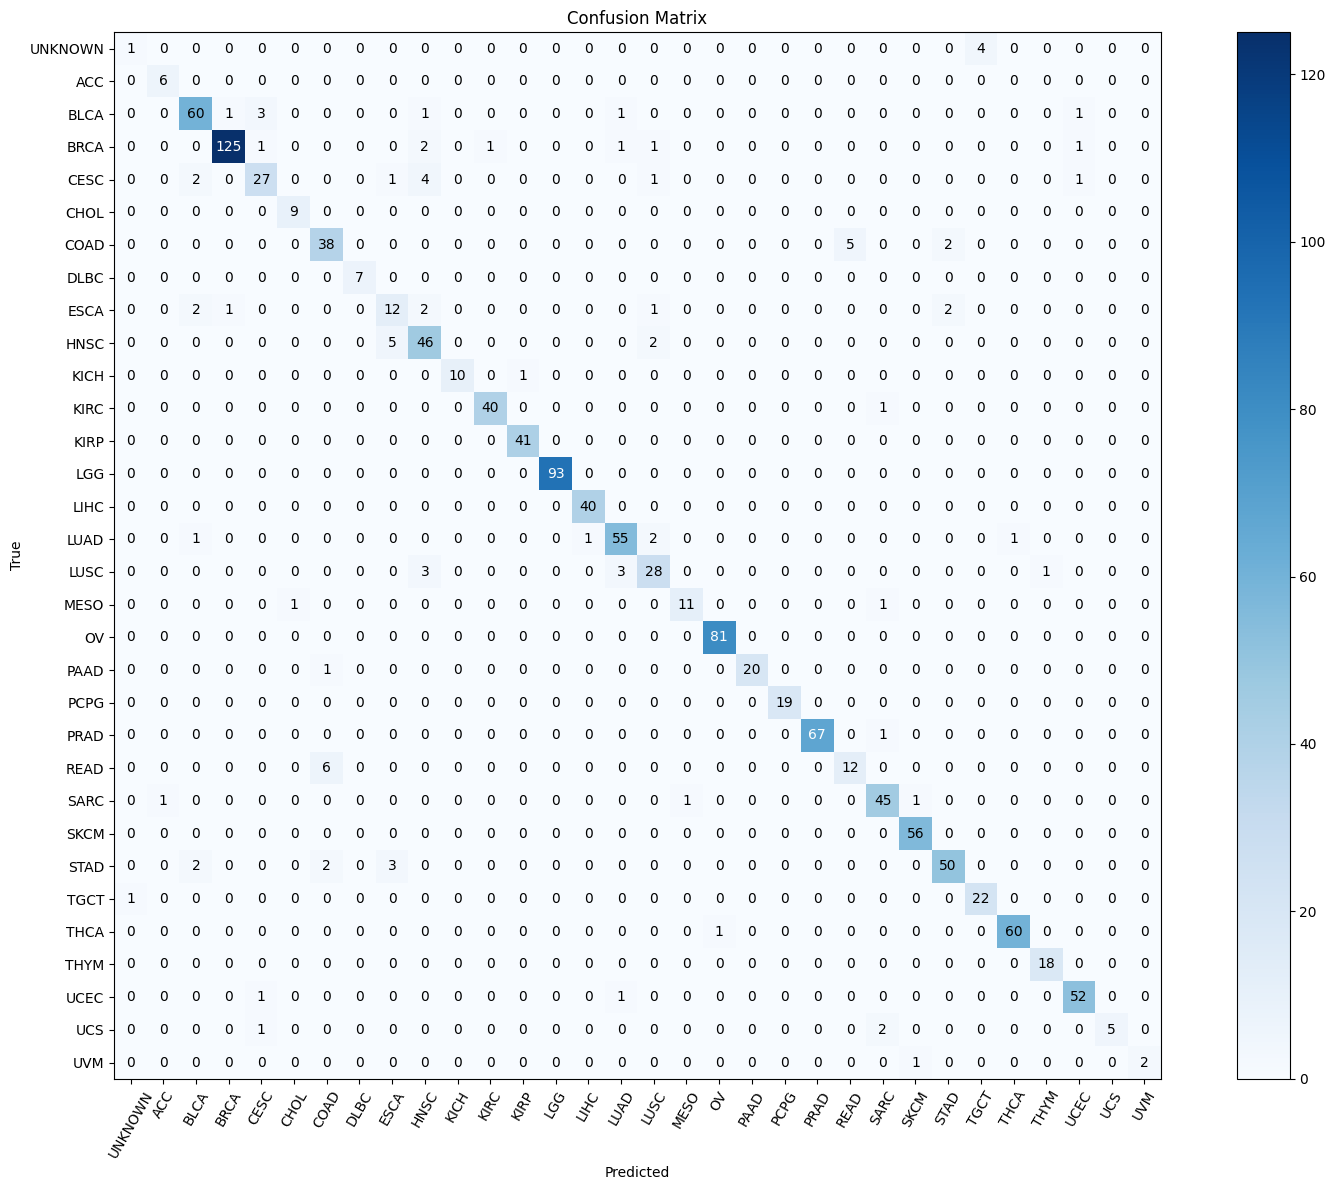

Done...in time:  578.317446231842


In [10]:
t2=time.time()
#kfold = KFold(n_splits=10, shuffle=True)
clf = StackingClassifier(estimators=intermediate, final_estimator=LogisticRegression()) #MLPClassifier()

clf.fit(new_x_train , y_train)
#score = cross_val_score(stack_model,new_X,y,cv = 10,scoring = 'accuracy')
#score
y_predict=clf.predict(new_x_test)
acc=accuracy_score(y_predict,y_test)
prc=precision_score(y_predict,y_test, average='weighted')
rec=recall_score(y_predict,y_test, average='weighted')
f1=f1_score(y_predict,y_test, average='weighted')
confus_matrix= classification_report(y_test, y_predict)

results ='Acc: %.2f' % (acc*100) + ', Pre: %.2f' % (prc*100)
results += ', Rec: %.2f' % (rec*100) + ', F1: %.2f' % (f1*100) + ', T:%.2f ' % (time.time()-t_temp) + ', PC:Tan'
results += ', Eb:%d ' %(num_epochs) + ', Bs:%d ' %(batch_size) + 'Dataset: ' + dataset + '\n'
results += 'Confusion matrix :\n' + confus_matrix + '=======================\n'


path2= path + "Res_Ensemble_DL.txt" # the name of the file
write_results(results, path2)

draw_cnf_mat.draw(y_test, y_predict, 'Res_Ensemble_DL')

print("Done...in time: ", time.time()-t2)

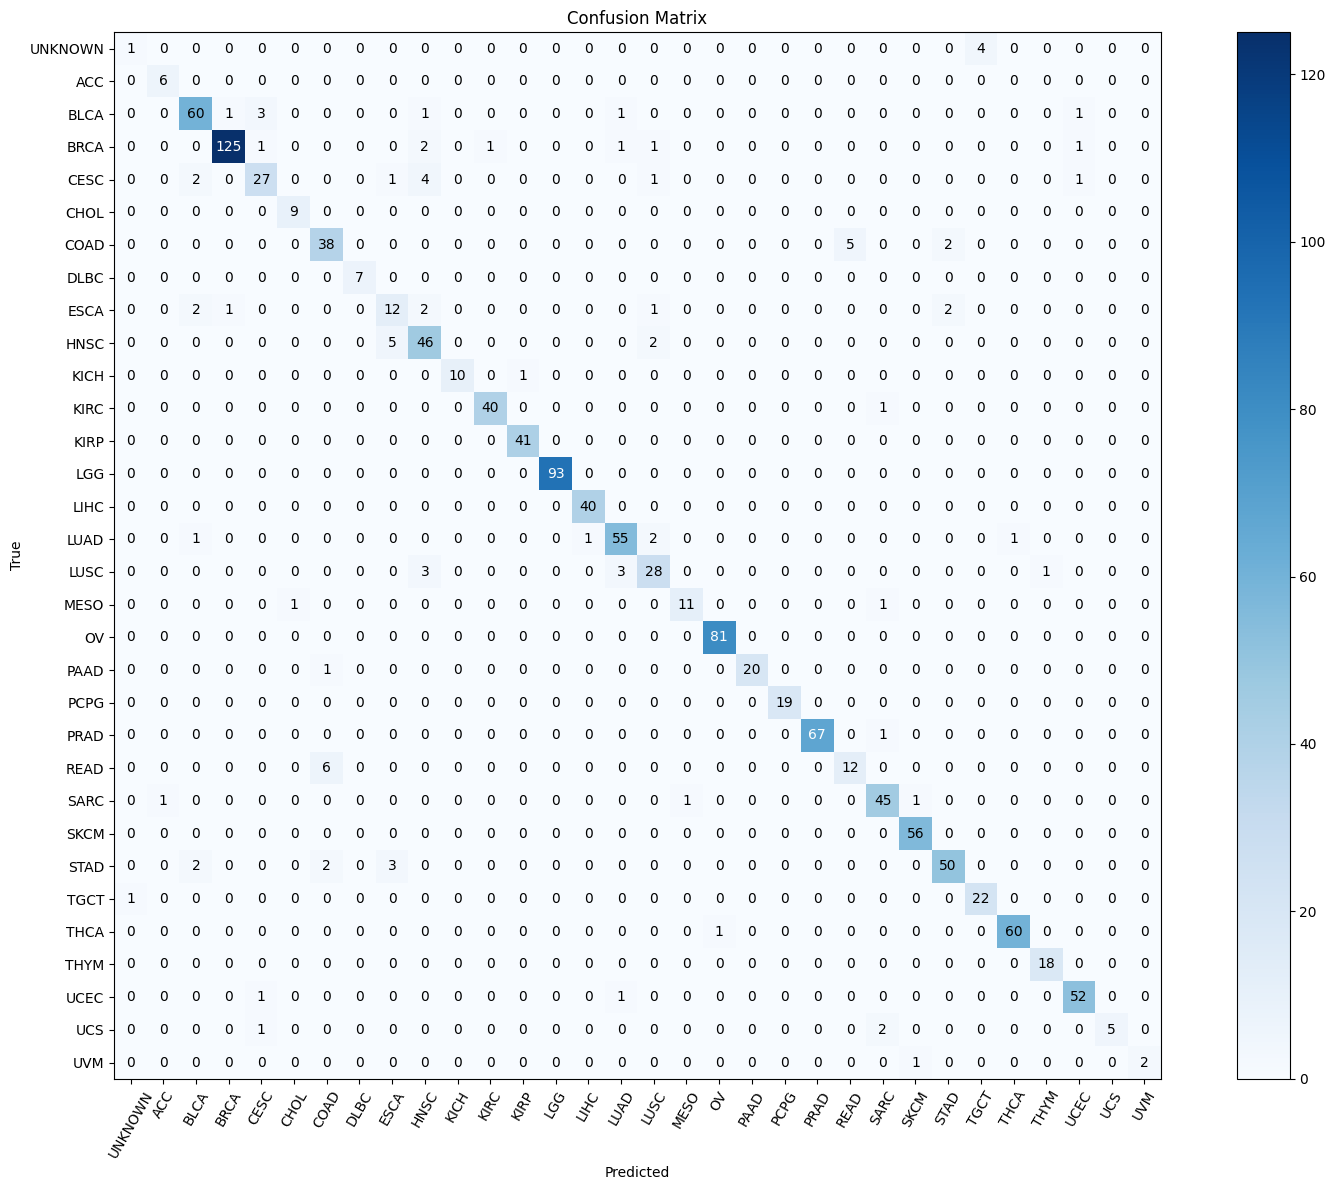

Done...in time:  582.9654023647308


In [11]:
draw_cnf_mat.draw(y_test, y_predict, 'Res_Ensemble_DL')

print("Done...in time: ", time.time()-t2)

In [12]:
print("Stacking model score: %.3f" % clf.score(new_x_test , y_test))

40/40 [==============================] - 0s 1ms/step
Stacking model score: 0.927


In [13]:
print(classification_report(y_predict,y_test), '\n')

              precision    recall  f1-score   support

         0.0       0.20      0.50      0.29         2
         1.0       1.00      0.86      0.92         7
         2.0       0.90      0.90      0.90        67
         3.0       0.95      0.98      0.97       127
         4.0       0.75      0.82      0.78        33
         5.0       1.00      0.90      0.95        10
         6.0       0.84      0.81      0.83        47
         7.0       1.00      1.00      1.00         7
         8.0       0.60      0.57      0.59        21
         9.0       0.87      0.79      0.83        58
        10.0       0.91      1.00      0.95        10
        11.0       0.98      0.98      0.98        41
        12.0       1.00      0.98      0.99        42
        13.0       1.00      1.00      1.00        93
        14.0       1.00      0.98      0.99        41
        15.0       0.92      0.90      0.91        61
        16.0       0.80      0.80      0.80        35
        17.0       0.85    